In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [8]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "1INCHUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2022-01-01"
        self.end_date = "2022-03-04"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = True  # set to False to use 1s candles


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
if config["ohlcv"]:
    data = load_hlc_cache(
        config["symbol"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
error fetching fills string indices must be integers


Traceback (most recent call last):
  File "C:\AgodaGit\passivbot\binance.py", line 377, in fetch_fills
    fills = [
  File "C:\AgodaGit\passivbot\binance.py", line 379, in <listcomp>
    "symbol": x["symbol"],
TypeError: string indices must be integers


error with update position 0
millis to load 87839 ticks 13ms


Traceback (most recent call last):
  File "C:\AgodaGit\passivbot\passivbot.py", line 261, in update_position
    position = await self.fetch_position()
  File "C:\AgodaGit\passivbot\binance.py", line 267, in fetch_position
    assert all(
  File "C:\AgodaGit\passivbot\binance.py", line 268, in <genexpr>
    key in positions[0] for key in ["symbol", "positionAmt", "entryPrice"]
KeyError: 0


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

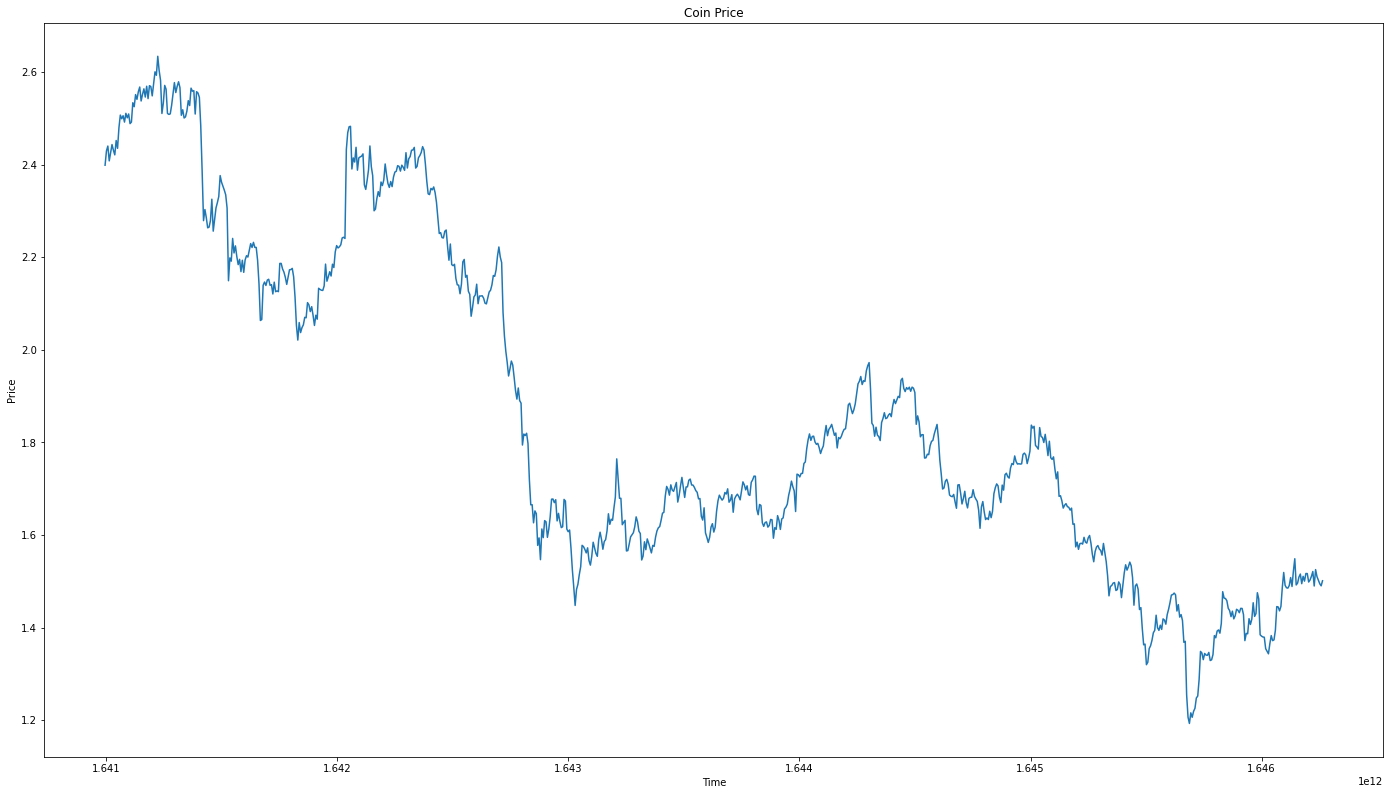

In [9]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [10]:
# choose a slice on which to test
wsize_days = 365
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [11]:
hand_tuned = {
    "config_name": "static_grid_1INCHUSDT_198days",
  "logging_level": 0,
  "long": {
    "auto_unstuck_ema_dist": 0.042442783008452035,
    "auto_unstuck_wallet_exposure_threshold": 0.9207998186225945,
    "ema_span_0": 1467.1216021417815,
    "ema_span_1": 2043.845592884267,
    "enabled": True,
    "eprice_exp_base": 1.2989141602944303,
    "eprice_pprice_diff": 0.023662414633603666,
    "grid_span": 0.25583954425089916,
    "initial_eprice_ema_dist": -0.03483738044116901,
    "initial_qty_pct": 0.08880814000569119,
    "markup_range": 0.029644924465494327,
    "max_n_entry_orders": 10,
    "min_markup": 0.036898444463317574,
    "n_close_orders": 8,
    "secondary_allocation": 0.390336852863754,
    "secondary_pprice_diff": 0.1683363553192447,
    "wallet_exposure_limit": 0.1
  },
  "short": {
    "auto_unstuck_ema_dist": 0.07692067495670571,
    "auto_unstuck_wallet_exposure_threshold": 0.367480315605299,
    "ema_span_0": 3949.259795824885,
    "ema_span_1": 10080,
    "enabled": True,
    "eprice_exp_base": 1.326708275533179,
    "eprice_pprice_diff": 0.014175680093106852,
    "grid_span": 0.25833394408930865,
    "initial_eprice_ema_dist": -0.06507125117727211,
    "initial_qty_pct": 0.0892236921421297,
    "markup_range": 0.0355007427669179,
    "max_n_entry_orders": 10,
    "min_markup": 0.04689404279519703,
    "n_close_orders": 5,
    "secondary_allocation": 0.056988382388130296,
    "secondary_pprice_diff": 0.3989914574846171,
    "wallet_exposure_limit": 0.14088425874015464
  }
}

# hand_tuned = load_live_config('configs/live/allround.json')
# hand_tuned['short']['enabled'] = True
config["starting_balance"] = Args().starting_balance
config["latency_simulation_ms"] = 1000
config_to_test = {**config, **numpyize(hand_tuned)}
dump_live_config(config_to_test, make_get_filepath(f"tmp/hand_tuned.json"))
hand_tuned

{'config_name': 'static_grid_1INCHUSDT_198days',
 'logging_level': 0,
 'long': {'auto_unstuck_ema_dist': 0.042442783008452035,
  'auto_unstuck_wallet_exposure_threshold': 0.9207998186225945,
  'ema_span_0': 1467.1216021417815,
  'ema_span_1': 2043.845592884267,
  'enabled': True,
  'eprice_exp_base': 1.2989141602944303,
  'eprice_pprice_diff': 0.023662414633603666,
  'grid_span': 0.25583954425089916,
  'initial_eprice_ema_dist': -0.03483738044116901,
  'initial_qty_pct': 0.08880814000569119,
  'markup_range': 0.029644924465494327,
  'max_n_entry_orders': 10,
  'min_markup': 0.036898444463317574,
  'n_close_orders': 8,
  'secondary_allocation': 0.390336852863754,
  'secondary_pprice_diff': 0.1683363553192447,
  'wallet_exposure_limit': 0.1},
 'short': {'auto_unstuck_ema_dist': 0.07692067495670571,
  'auto_unstuck_wallet_exposure_threshold': 0.367480315605299,
  'ema_span_0': 3949.259795824885,
  'ema_span_1': 10080,
  'enabled': True,
  'eprice_exp_base': 1.326708275533179,
  'eprice_pp

In [12]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 305.0882
{'DGstd_long': 0.0032473544599387915,
 'DGstd_short': 0.0022524398854954527,
 'adg_DGstd_ratio_long': -0.13528748757184472,
 'adg_DGstd_ratio_short': 0.1786039944898689,
 'adg_long': -0.00043932642614034374,
 'adg_per_exposure_long': -0.004393264261403437,
 'adg_per_exposure_short': 0.0028554982969373377,
 'adg_short': 0.00040229476089779083,
 'avg_fills_per_day_long': 5.147599585605483,
 'avg_fills_per_day_short': 4.4262798984505745,
 'biggest_psize_long': 708.0,
 'biggest_psize_quote_long': 1000.4377722230329,
 'biggest_psize_quote_short': 1410.9639000000002,
 'biggest_psize_short': 596.0,
 'closest_bkr_long': 1.0,
 'closest_bkr_short': 1.0,
 'eqbal_ratio_mean_long': 0.9941338722006511,
 'eqbal_ratio_mean_short': 0.9992301545864539,
 'eqbal_ratio_min_long': 0.9624652340152413,
 'eqbal_ratio_min_short': 0.9881725062218558,
 'exchange': 'binance',
 'fee_sum_long': -4.08006532,
 'fee_sum_short': -2.2077337600000004,
 'final_balance_long': 9733.610534680009,
 'fi

In [13]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1640995260000.0,0.0,0.0000000000,0.0,0.0000,0.0,0.0000000000,2.3986,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.000000000,0.0000000000
1,1640995320000.0,0.0,0.0000000000,0.0,0.0000,0.0,0.0000000000,2.4007,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.000000000,0.0000000000
2,1640995380000.0,0.0,0.0000000000,0.0,0.0000,0.0,0.0000000000,2.3959,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.000000000,0.0000000000
3,1640995440000.0,0.0,0.0000000000,0.0,0.0000,0.0,0.0000000000,2.3964,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.000000000,0.0000000000
4,1640995500000.0,0.0,0.0000000000,0.0,0.0000,0.0,0.0000000000,2.3989,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87835,1646265360000.0,0.0,30.9407174317,57.0,1.5166,-348.0,1.4497063367,1.4923,1.0,1.0,9733.61053468,10262.8718610674,9732.22543468,10248.04926624,0.008881206,0.0491575664
87836,1646265420000.0,0.0,30.9407174317,57.0,1.5166,-348.0,1.4497063367,1.4938,1.0,1.0,9733.61053468,10262.8718610674,9732.31093468,10247.52726624,0.008881206,0.0491575664
87837,1646265480000.0,0.0,30.9407174317,57.0,1.5166,-348.0,1.4497063367,1.4947,1.0,1.0,9733.61053468,10262.8718610674,9732.36223468,10247.21406624,0.008881206,0.0491575664
87838,1646265540000.0,0.0,30.9407174317,57.0,1.5166,-348.0,1.4497063367,1.4958,1.0,1.0,9733.61053468,10262.8718610674,9732.42493468,10246.83126624,0.008881206,0.0491575664


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

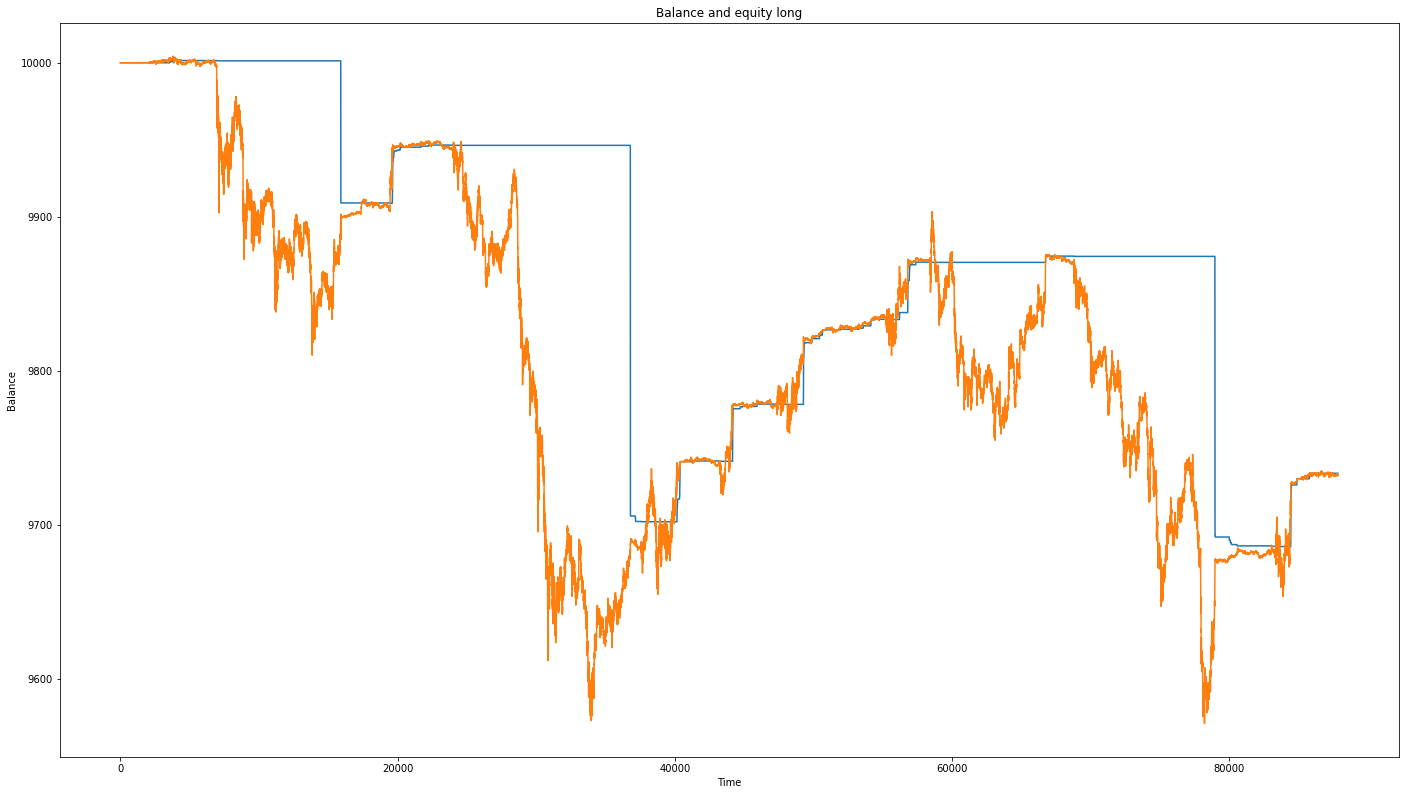

In [14]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

In [ ]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

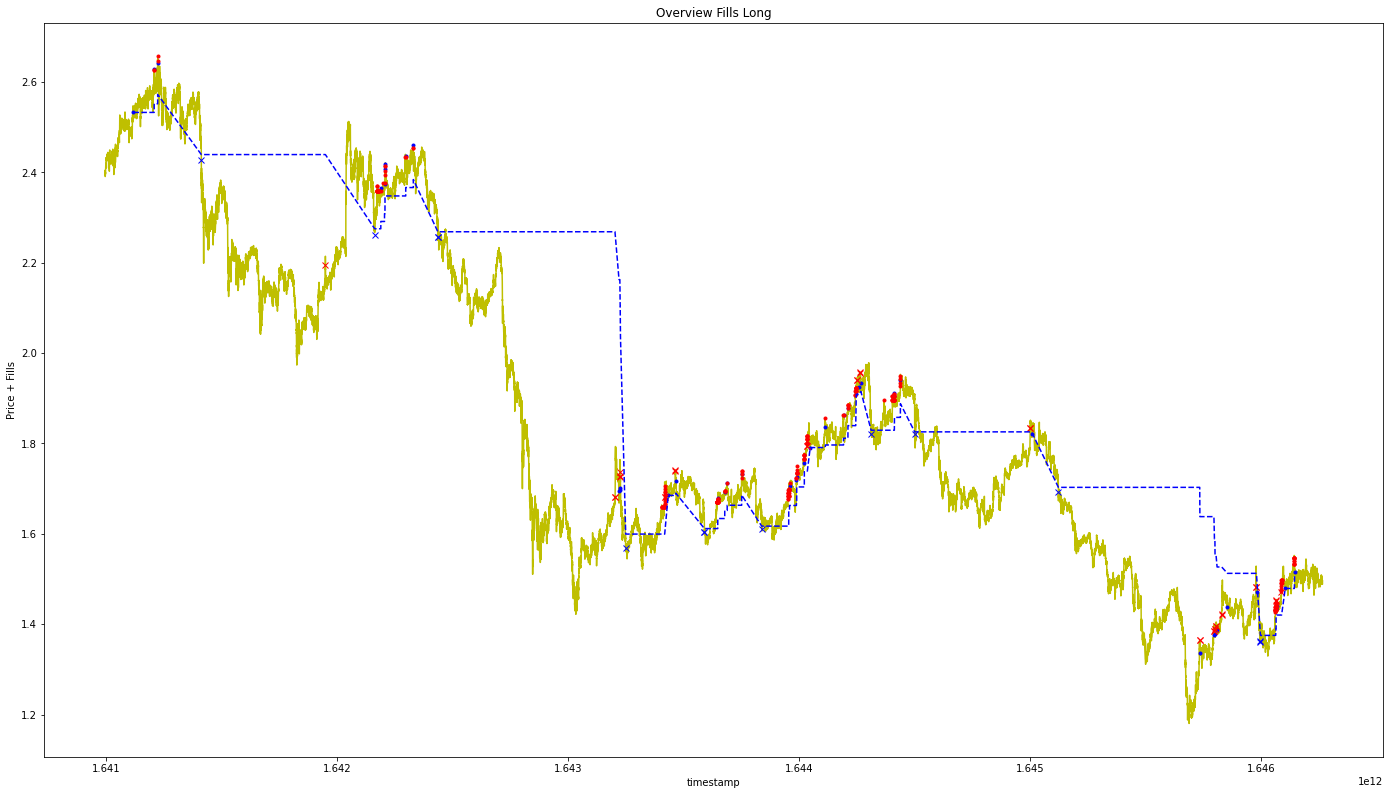

In [15]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

In [ ]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Long Position size'>

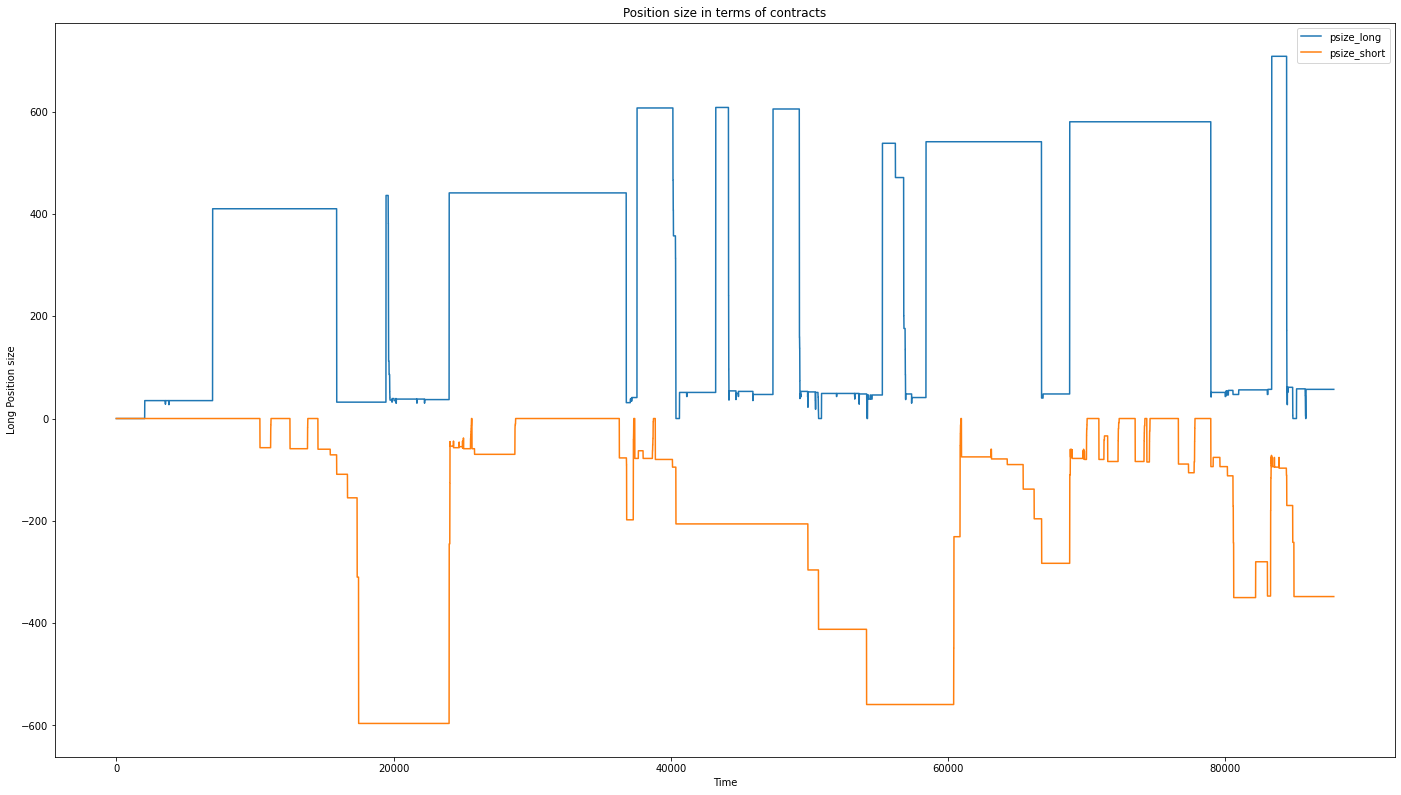

In [16]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

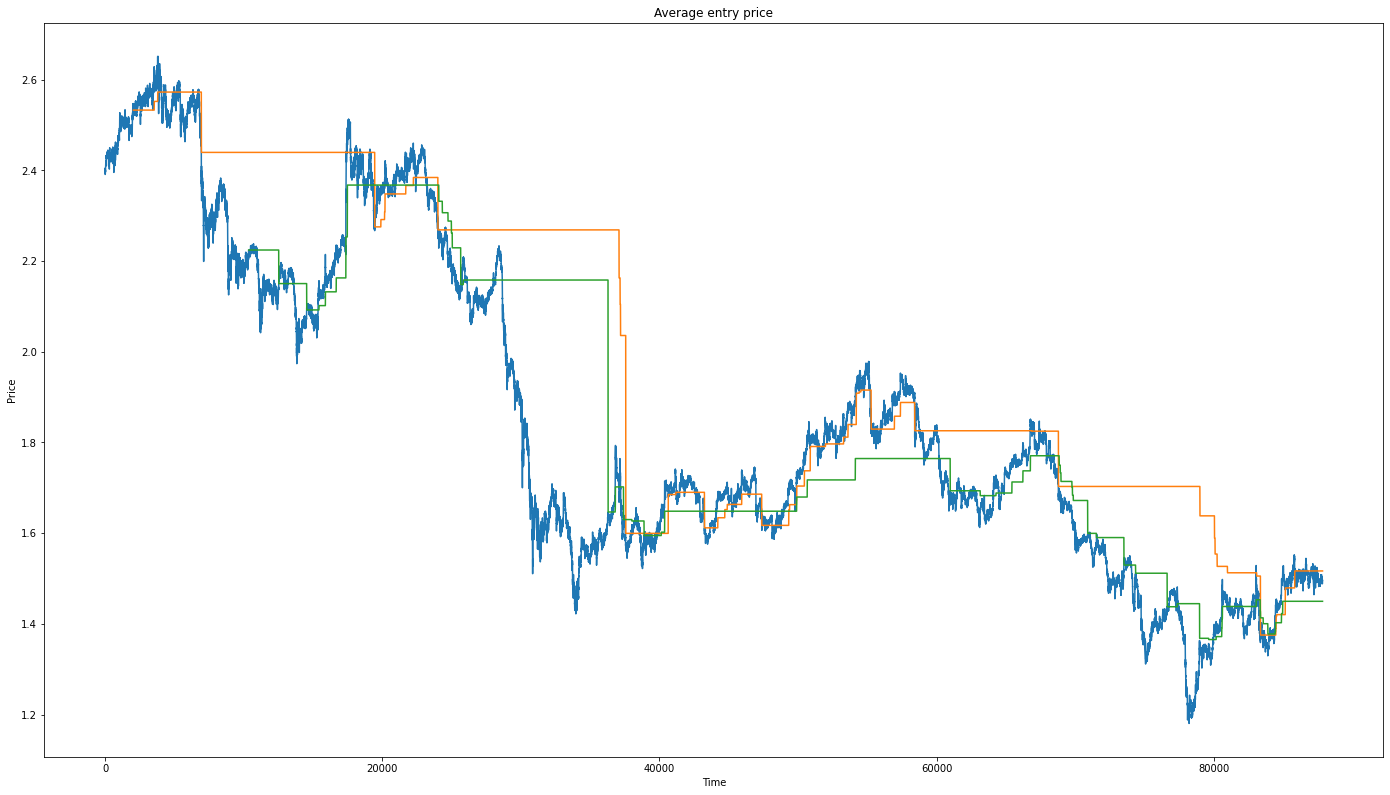

In [17]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf.pprice_long.replace(0.0, np.nan).plot()
sdf.pprice_short.replace(0.0, np.nan).plot()

Mean price action distance long 0.091503


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

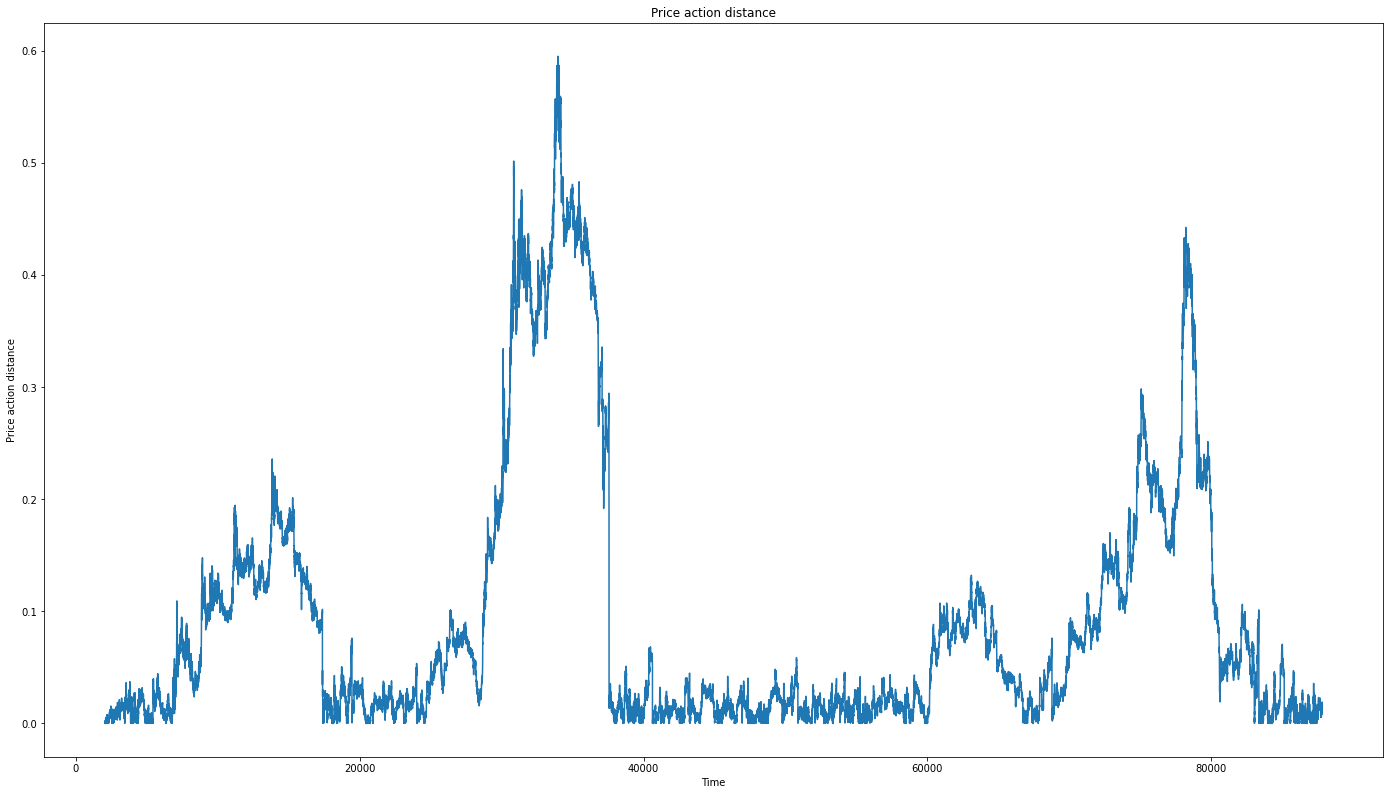

In [18]:
lpprices = sdf[sdf.pprice_long != 0.0]
pa_distance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Mean price action distance long {pa_distance_long.mean():.6f}")
pa_distance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.057713


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

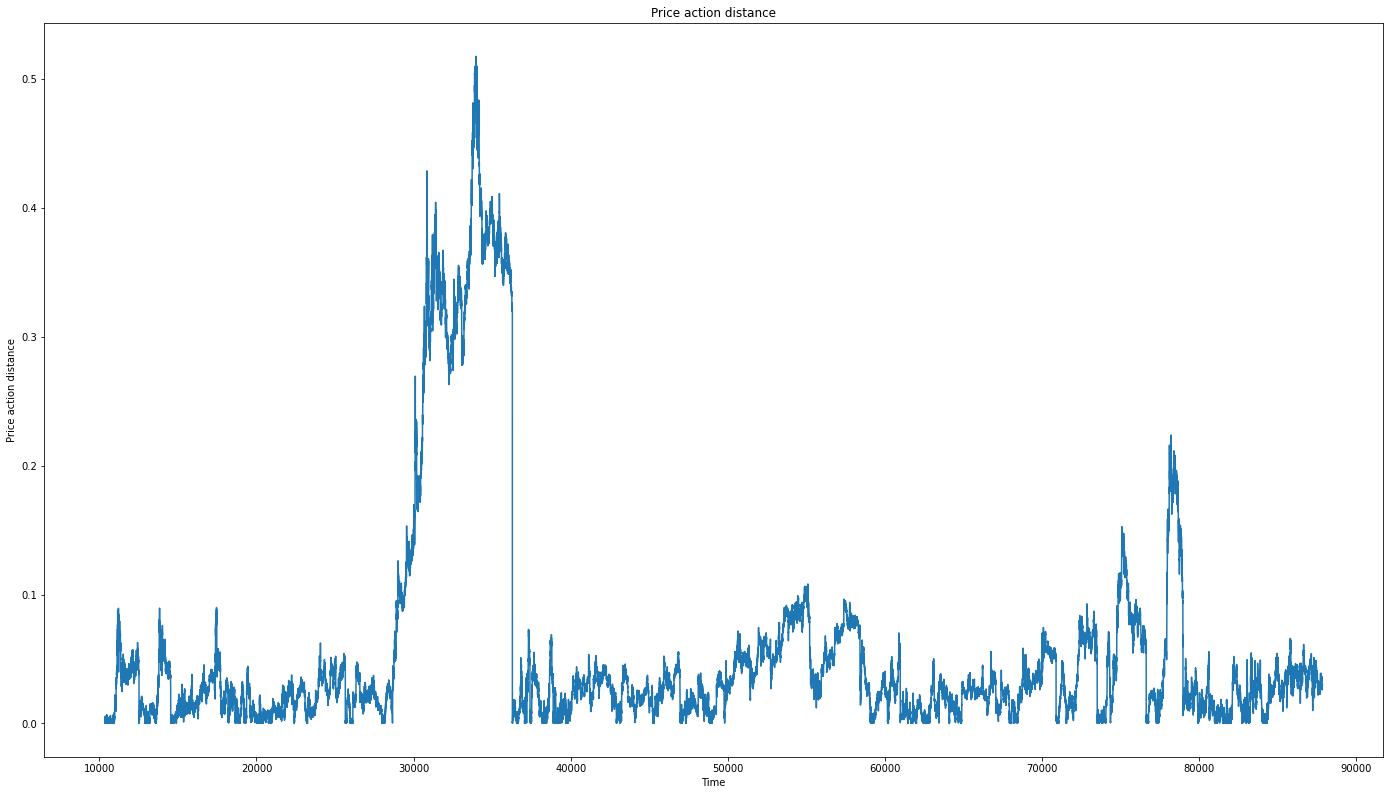

In [19]:
spprices = sdf[sdf.pprice_short != 0.0]
pa_distance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {pa_distance_short.mean():.6f}")
pa_distance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [1467.1216021417815, 1731.6379589171593, 2043.845592884267] n_days 61.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

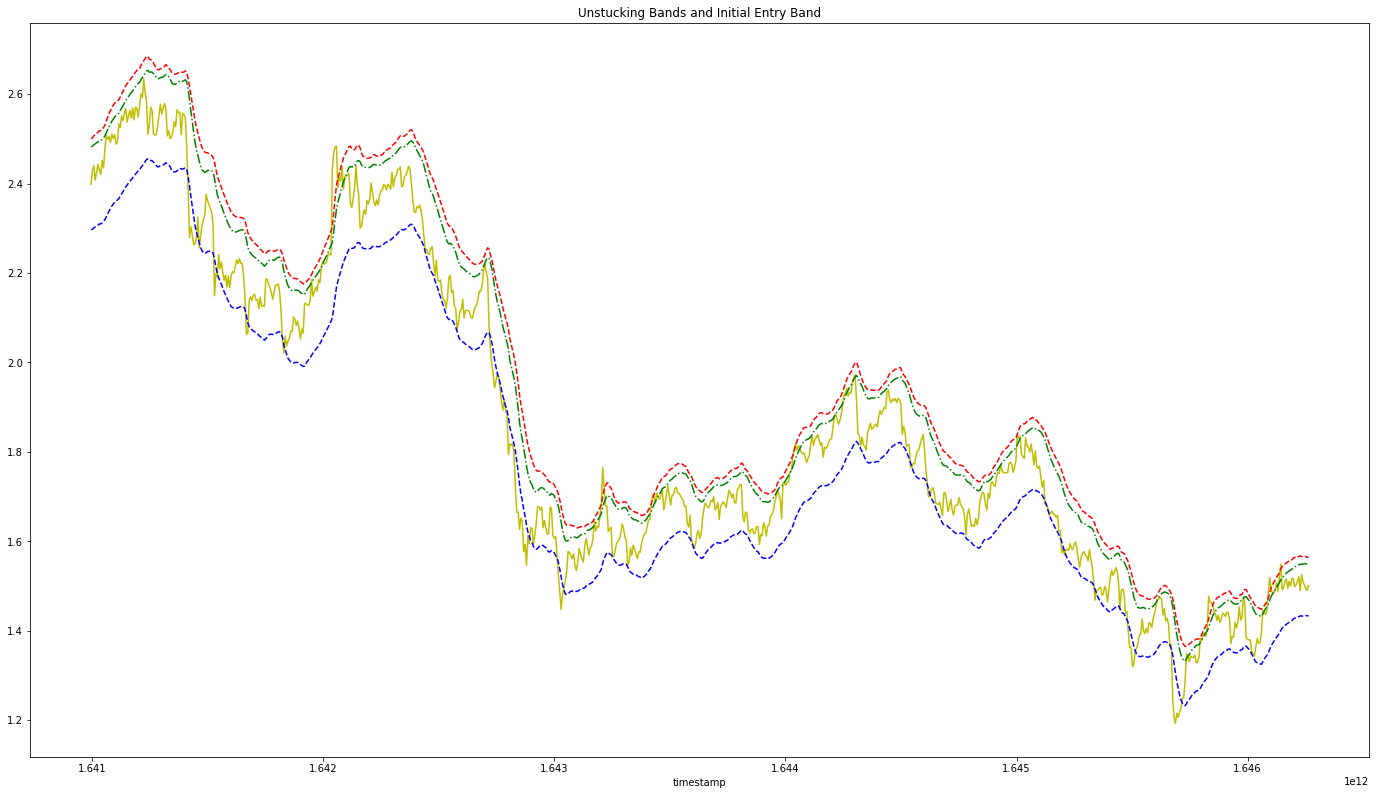

In [20]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [3949.259795824885, 6309.40082273387, 10080] n_days 61.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

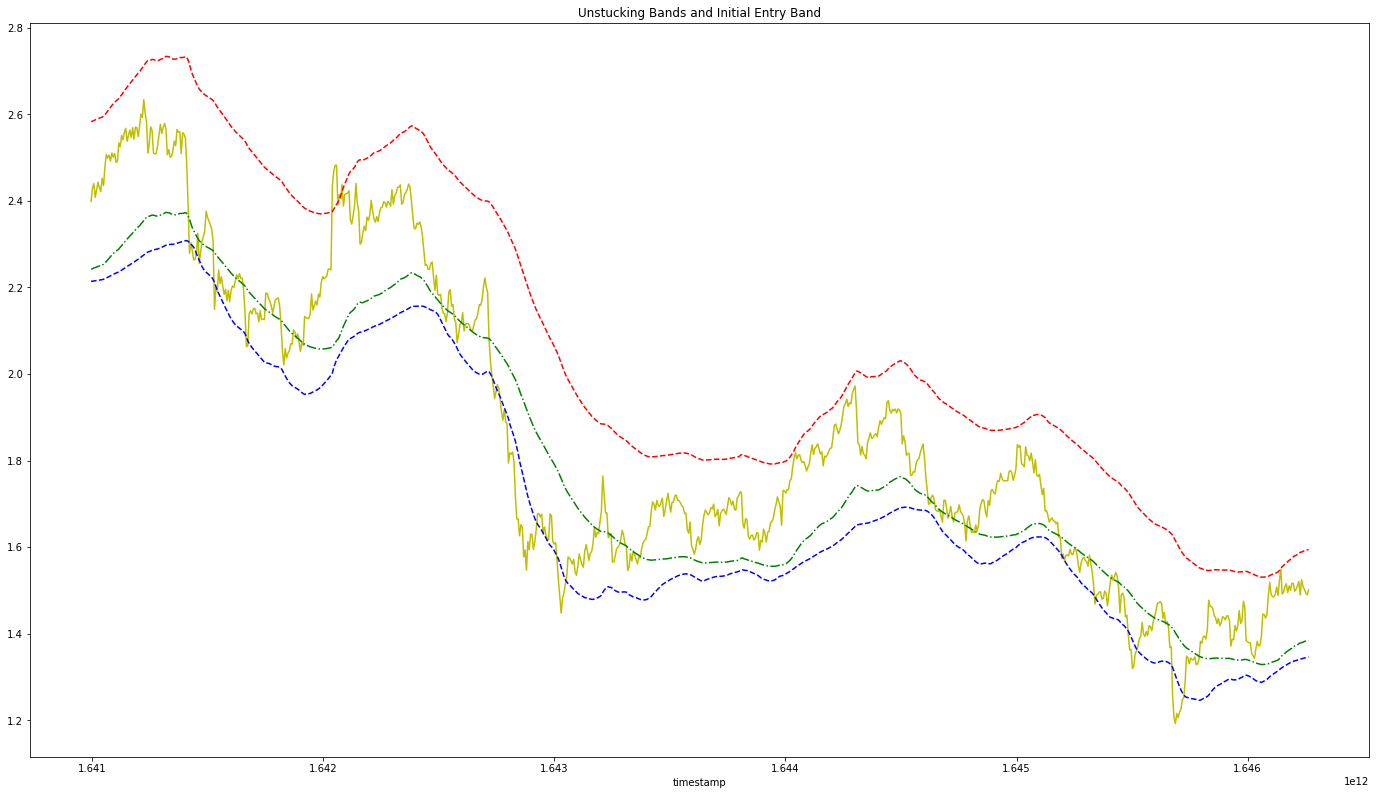

In [21]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")

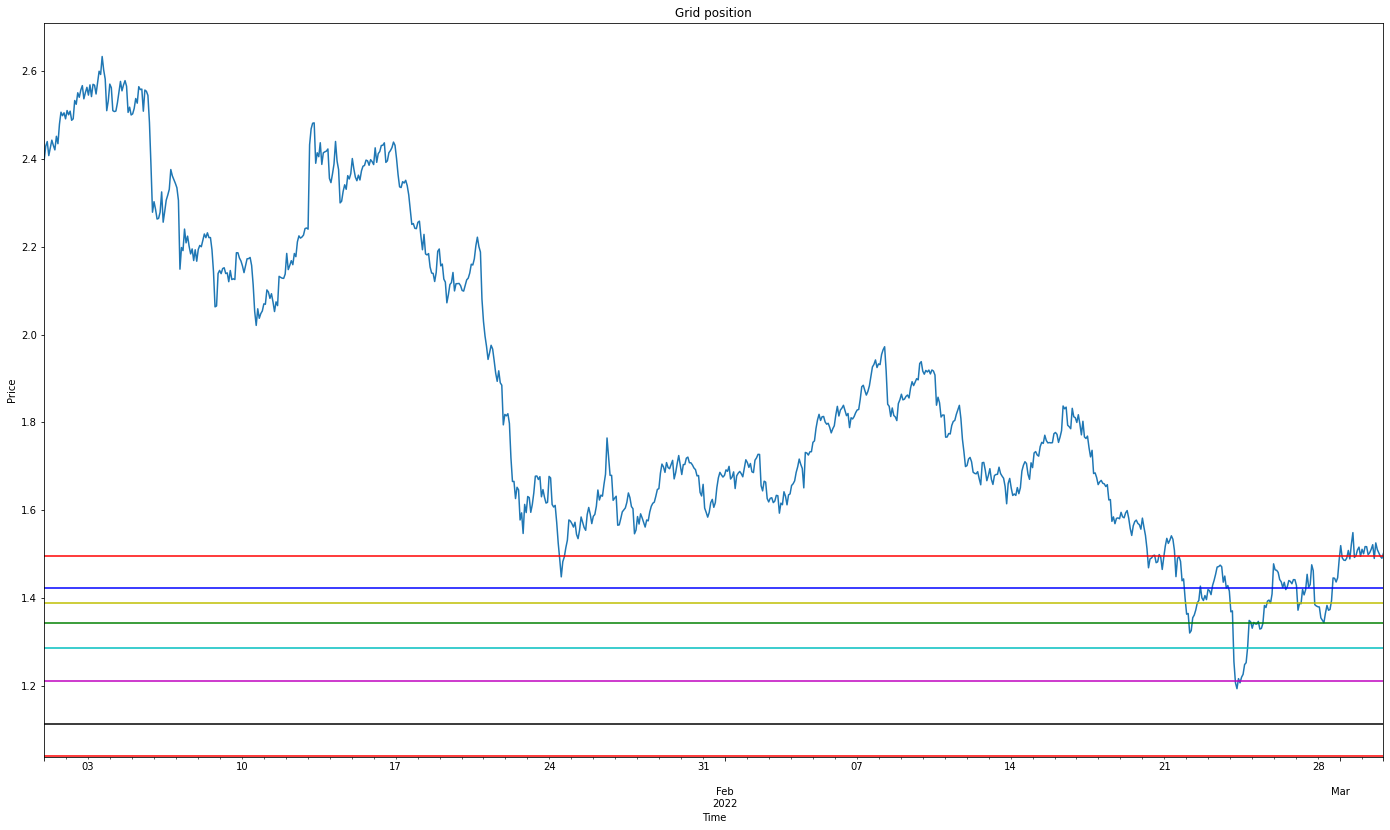

In [22]:
balance = config_to_test["starting_balance"]
highest_bid = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_long = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["long"]["grid_span"]
wallet_exposure_limit = config_to_test["long"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["long"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["long"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["long"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["long"]["eprice_exp_base"]
secondary_allocation = config_to_test["long"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["long"]["secondary_pprice_diff"]

grid = calc_whole_entry_grid_long(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [23]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nLong Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Long Grid Span = 30.55 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,59.0,1.4958,59.0,1.4958000000,0.00882522,0.0000000000,NaN,0.0
1,10.0,1.4216,69.0,1.4850463768,0.01024682,0.0446302594,0.1694915254,0.0
2,33.0,1.3874,102.0,1.4534549020,0.01482524,0.0476105679,0.4782608696,0.0
3,41.0,1.3430,143.0,1.4217860140,0.02033154,0.0586641951,0.4019607843,0.0
4,69.0,1.2853,212.0,1.3773636792,0.02920011,0.0716281640,0.4825174825,0.0
5,104.0,1.2104,316.0,1.3224136076,0.04178827,0.0925426368,0.4905660377,0.0
6,170.0,1.1131,486.0,1.2491969136,0.06071097,0.1222683619,0.5379746835,0.0
7,378.0,1.0389,864.0,1.1571920139,0.09998139,0.1138627528,0.7777777778,0.0


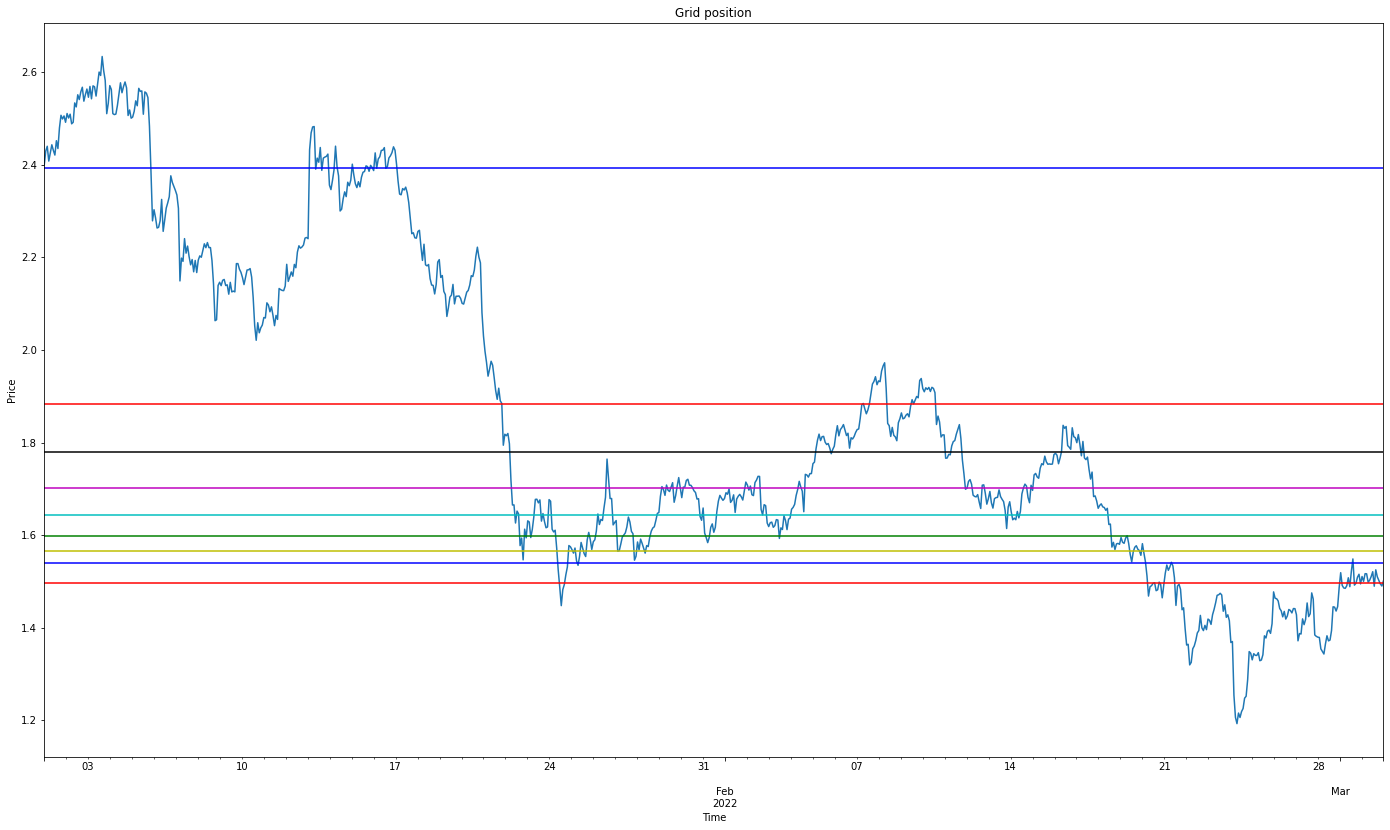

In [24]:
balance = config_to_test["starting_balance"]
lowest_ask = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_short = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["short"]["grid_span"]
wallet_exposure_limit = config_to_test["short"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["short"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["short"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["short"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["short"]["eprice_exp_base"]
secondary_allocation = config_to_test["short"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["short"]["secondary_pprice_diff"]

grid = calc_whole_entry_grid_short(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [25]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nShort Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Short Grid Span = -59.95 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,-84.0,1.4958,-84.0,1.4958000000,0.01256472,0.0000000000,NaN,120.5434190476
1,-16.0,1.5398,-100.0,1.5028400000,0.01502840,0.0240031173,0.1904761905,101.5028400000
2,-52.0,1.5649,-152.0,1.5240710526,0.02316588,0.0260904514,0.5200000000,67.3135447368
3,-65.0,1.5983,-217.0,1.5463055300,0.03355483,0.0325311081,0.4276315789,47.6292548387
4,-95.0,1.6425,-312.0,1.5755955128,0.04915858,0.0407333255,0.4377880184,33.6268775641
5,-122.0,1.7012,-434.0,1.6109036866,0.06991322,0.0530780116,0.3910256410,24.6523783410
6,-156.0,1.7790,-590.0,1.6553494915,0.09766562,0.0695056259,0.3594470046,18.6045020339
7,-188.0,1.8823,-778.0,1.7101910026,0.13305286,0.0914354765,0.3186440678,14.5636614396
8,-33.0,2.3926,-811.0,1.7379585697,0.14094844,0.2736108962,0.0424164524,14.0684147965
